# Riemannian Optimization for Inference in MoG models

The Mixture of Gaussians (MoG) model assumes that datapoints $\mathbf{x}_i\in\mathbb{R}^d$ follow a distribution described by the following probability density function:

$p(\mathbf{x}) = \sum_{m=1}^M \pi_m p_\mathcal{N}(\mathbf{x};\mathbf{\mu}_m,\mathbf{\Sigma}_m)$ where $\pi_m$ is the probability that the data point belongs to the $m^\text{th}$ mixture component and $p_\mathcal{N}(\mathbf{x};\mathbf{\mu}_m,\mathbf{\Sigma}_m)$ is the probability density function of a multivariate Gaussian distribution with mean $\mathbf{\mu}_m \in \mathbb{R}^d$ and psd covariance matrix $\mathbf{\Sigma}_m \in \{\mathbf{M}\in\mathbb{R}^{d\times d}: \mathbf{M}\succeq 0\}$.

As an example consider the mixture of three Gaussians with means
$\mathbf{\mu}_1 = \begin{bmatrix} -4 \\ 1 \end{bmatrix}$,
$\mathbf{\mu}_2 = \begin{bmatrix} 0 \\ 0 \end{bmatrix}$ and
$\mathbf{\mu}_3 = \begin{bmatrix} 2 \\ -1 \end{bmatrix}$, covariances
$\mathbf{\Sigma}_1 = \begin{bmatrix} 3 & 0 \\ 0 & 1 \end{bmatrix}$,
$\mathbf{\Sigma}_2 = \begin{bmatrix} 1 & 1 \\ 1 & 3 \end{bmatrix}$ and
$\mathbf{\Sigma}_3 = \begin{bmatrix} 0.5 & 0 \\ 0 & 0.5 \end{bmatrix}$
and mixture probability vector $\boldsymbol{\pi}=\left[0.1, 0.6, 0.3\right]^\top$.
Let's generate $N=1000$ samples of that MoG model and scatter plot the samples:

Dataset generated. Visualizing the ground truth...


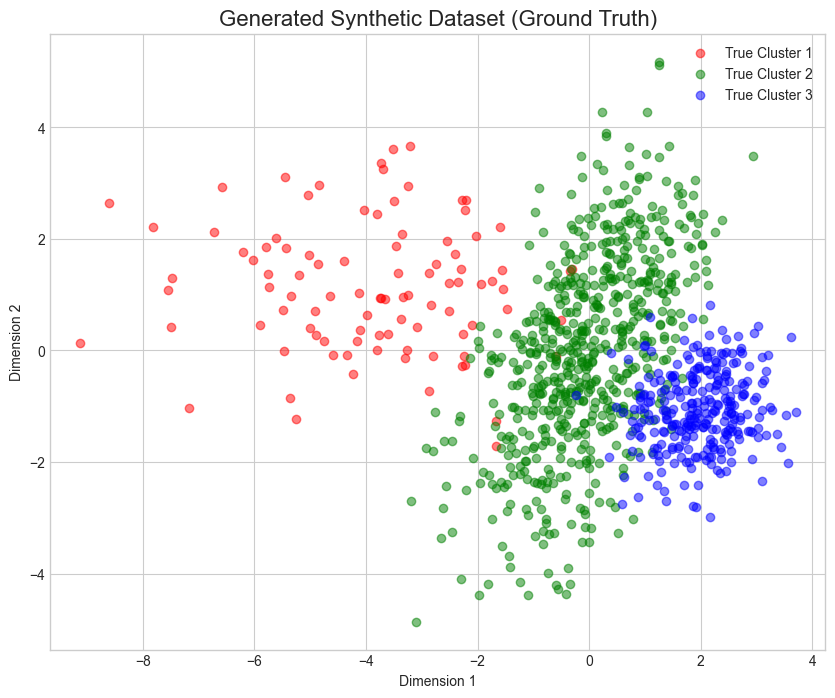

In [1]:
# CODE 1: SYNTHETIC DATA GENERATION AND VISUALIZATION
# ----------------------------------------------------

# 1. Required Libraries
import autograd.numpy as np
import matplotlib.pyplot as plt
import warnings

# Suppress the specific "invalid value" RuntimeWarning from Pymanopt's ConjugateGradient.
# This is a benign warning that occurs upon successful convergence.
warnings.filterwarnings(
    "ignore",
    message="invalid value encountered in scalar divide",
    category=RuntimeWarning,
)

%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
np.set_printoptions(precision=2, suppress=True)

# --- Step 1: Define Dataset Parameters ---
N = 1000  # Number of data points
D = 2     # Dimension of each data point
K = 3     # Number of clusters

# Ground Truth model parameters
pi = [0.1, 0.6, 0.3]
mu = [np.array([-4, 1]), np.array([0, 0]), np.array([2, -1])]
Sigma = [
    np.array([[3.0, 0.0], [0.0, 1.0]]),
    np.array([[1.0, 1.0], [1.0, 3.0]]),
    0.5 * np.eye(D)
]

# --- Step 2: Generate Synthetic Data from Parameters ---
components = np.random.choice(K, size=N, p=pi)
samples = np.zeros((N, D))
for k in range(K):
    indices = (k == components)
    n_k = indices.sum()
    if n_k > 0:
        samples[indices, :] = np.random.multivariate_normal(mu[k], Sigma[k], size=n_k)

# --- Step 3: Visualize the Generated Data ---
print("Dataset generated. Visualizing the ground truth...")
plt.figure(figsize=(10, 8))
colors = ["red", "green", "blue", "cyan", "magenta"]
for k in range(K):
    indices = (k == components)
    plt.scatter(
        samples[indices, 0], samples[indices, 1],
        alpha=0.5, color=colors[k % K], label=f'True Cluster {k+1}'
    )
plt.title('Generated Synthetic Dataset (Ground Truth)', fontsize=16)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.axis('equal')
plt.show()

# After running this cell, the variables `N`, `D`, `K`, and `samples`
# will remain in memory and can be used by the next cell (Code 2).

Given a data sample the de facto standard method to infer the parameters is the [expectation maximisation](https://en.wikipedia.org/wiki/Expectation-maximization_algorithm) (EM) algorithm that, in alternating so-called E and M steps, maximises the log-likelihood of the data.
In [arXiv:1506.07677](http://arxiv.org/pdf/1506.07677v1.pdf) Hosseini and Sra propose Riemannian optimisation as a powerful counterpart to EM. Importantly, they introduce a reparameterisation that leaves local optima of the log-likelihood unchanged while resulting in a geodesically convex optimisation problem over a product manifold $\prod_{m=1}^M\mathcal{PD}^{(d+1)\times(d+1)}$ of manifolds of $(d+1)\times(d+1)$ symmetric positive definite matrices.
The proposed method is on par with EM and shows less variability in running times.

The reparameterised optimisation problem for augmented data points $\mathbf{y}_i=[\mathbf{x}_i^\top, 1]^\top$ can be stated as follows:

$$\min_{(\mathbf{S}_1, ..., \mathbf{S}_m, \boldsymbol{\nu}) \in \mathcal{D}}
-\sum_{n=1}^N\log\left(
\sum_{m=1}^M \frac{\exp(\nu_m)}{\sum_{k=1}^M\exp(\nu_k)}
q_\mathcal{N}(\mathbf{y}_n;\mathbf{S}_m)
\right)$$

where

* $\mathcal{D} := \left(\prod_{m=1}^M \mathcal{PD}^{(d+1)\times(d+1)}\right)\times\mathbb{R}^{M-1}$ is the search space
* $\mathcal{PD}^{(d+1)\times(d+1)}$ is the manifold of symmetric positive definite
$(d+1)\times(d+1)$ matrices
* $\mathcal{\nu}_m = \log\left(\frac{\alpha_m}{\alpha_M}\right), \ m=1, ..., M-1$ and $\nu_M=0$
* $q_\mathcal{N}(\mathbf{y}_n;\mathbf{S}_m) =
2\pi\exp\left(\frac{1}{2}\right)
|\operatorname{det}(\mathbf{S}_m)|^{-\frac{1}{2}}(2\pi)^{-\frac{d+1}{2}}
\exp\left(-\frac{1}{2}\mathbf{y}_i^\top\mathbf{S}_m^{-1}\mathbf{y}_i\right)$

**Optimisation problems like this can easily be solved using Pymanopt – even without the need to differentiate the cost function manually!**

So let's infer the parameters of our toy example by Riemannian optimisation using Pymanopt:

Choosing an optimization algorithm is like choosing a tool to reach a destination. Imagine we are trying to get to the summit of a mountain.

#### 1. Steepest Descent

*   **Analogy:** This is like always following the path that appears steepest downhill from your current position, at every single step.
*   **Advantage:** It's the simplest method to understand and implement. What to do at each step is very clear: move in the direction opposite to the gradient.
*   **Disadvantage:** It can be extremely slow, especially in narrow, elongated valleys (in optimization terms, "ill-conditioned" problems). If the path to the summit is not straight but winding, it will keep bouncing from one side of the valley to the other, making very slow progress toward the goal. This "zigzagging" behavior makes it inefficient for most practical problems.

#### 2. Conjugate Gradient

*   **Analogy:** This is like not only following the steepest path but also gaining "momentum" by remembering the direction you came from in the previous step. If you are descending one side of a valley, it encourages you to move along the valley floor instead of immediately climbing up the other side.
*   **Advantage:** It largely solves the zigzagging problem of `Steepest Descent`. By using past information (the previous search direction), it takes "smarter" steps and reaches the target much faster. It generally requires far fewer iterations than `Steepest Descent` and has low memory usage.
*   **Disadvantage:** Its underlying mathematics are slightly more complex.

#### 3. Trust-Regions

*   **Analogy:** This is like asking at each step, "What is the lowest point within a 100-meter circle of my current location?" You define a "trust region" where you believe your model (your map) is reliable, and you try to find the best step *within* that region.
*   **Advantage:** It is generally the most robust and reliable method. No matter how complex the problem's structure (highly curved, "non-convex" surfaces), it has a high probability of finding a good step. It uses the Hessian matrix (second-derivative information) to know more about the curvature of the surface, which makes it very powerful.
*   **Disadvantage:** It requires more computation at each step (it needs to solve a subproblem). Therefore, each individual iteration might be slower than the others, but it can reach the solution in fewer total iterations.

#### In Summary, Why Choose `ConjugateGradient` or `TrustRegions`?

**Because `SteepestDescent` is often too slow to be practical.** `ConjugateGradient` offers a fantastic balance between speed and simplicity. `TrustRegions` is the most robust option for more challenging and complex problems. In modern libraries like Pymanopt, `SteepestDescent` is usually included only for educational purposes or as a fallback for very simple cases where other algorithms fail. For real-world problems, more advanced methods like `ConjugateGradient` or `TrustRegions` are almost always the preferred choice.

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Starting standard Pymanopt optimization...
Optimizing...
Terminated - min step_size reached after 107 iterations, 0.82 seconds.

Optimization complete.
----------------------------------------------------------------------
PARAMETER COMPARISON (GROUND TRUTH vs. LEARNED)
----------------------------------------------------------------------

--- Cluster 1 (Highest Weight) ---
Weight (pi):    	Ground Truth=0.10 	Learned=0.63
Mean (mu):      	Ground Truth=[-4  1] 	Learned=[-0.03 -0.04]
Covariance (Sigma):
Ground Truth:
[[3. 0.]
 [0. 1.]]
Learned:
[[1.05 0.92]
 [0.92 3.02]]

--- Cluster 2 (Highest Weight) ---
Weight (pi):    	Ground Truth=0.60 	Learned=0.27
Mean (mu):      	Ground Truth=[0 0] 	Learned=[ 1.99 -1.07]
Covariance (Sigma):
Ground Truth:
[[1. 1.]
 [1. 3.]]
Learned:
[[0.46 0.07]
 [0.07 0.47]]

--- Cluster 3 (Highest Weight) ---
Weight (pi):    	Ground Truth=0.30 	Learned=0.10
Mean (mu):      	Ground Truth=[ 2 -1] 	Learned=[-3.68  1.08]
Covariance (Sigma):
Ground Truth:
[[0.5 0. ]

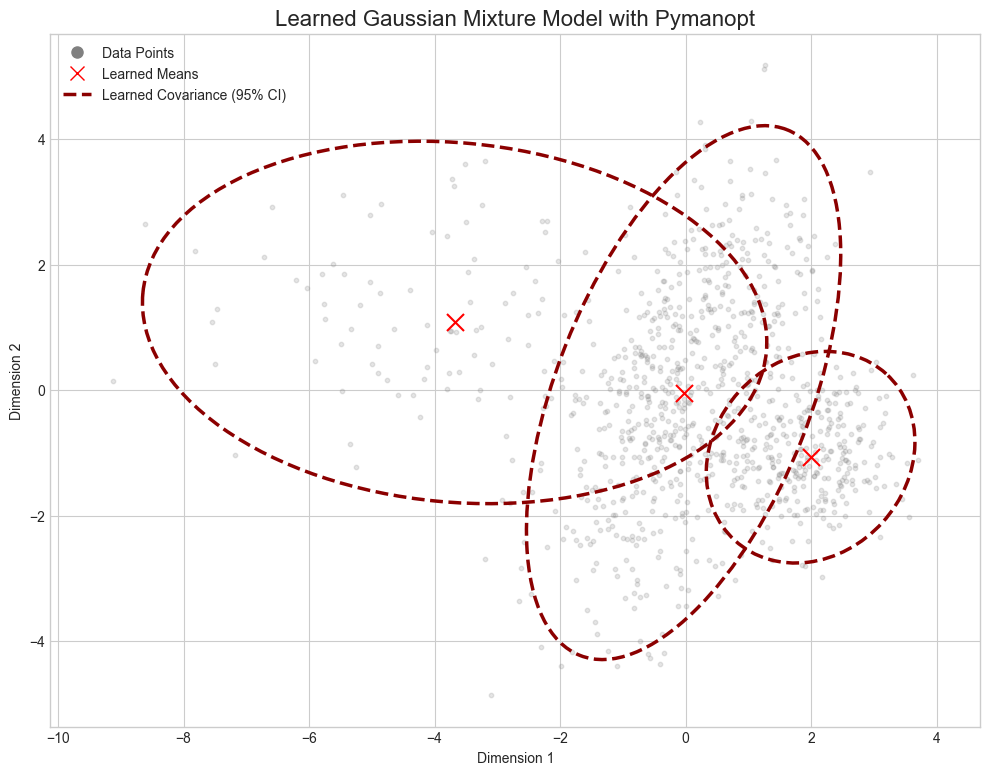


Learned Cluster Weights (alpha): [0.63 0.27 0.1 ]
Original Cluster Weights (pi):   [0.1, 0.6, 0.3]


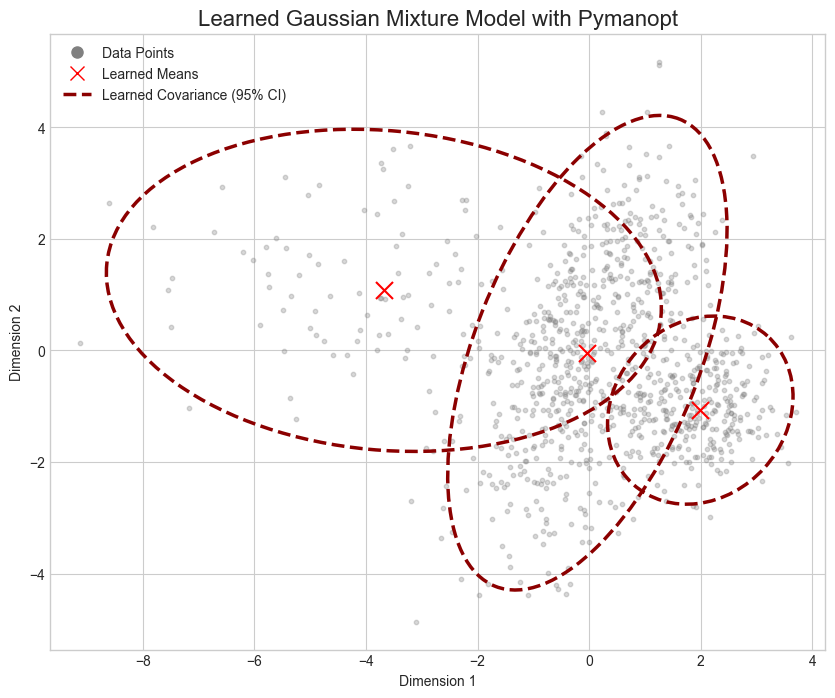

In [2]:
# CODE 2: GMM OPTIMIZATION WITH PYMANOPT
# --------------------------------------------
# This code must be run in the same environment (e.g., the same Jupyter Notebook)
# as Code 1, as it uses the variables `N`, `D`, `K`, and `samples`.

# 1. Required Pymanopt Libraries
from autograd.scipy.special import logsumexp
import pymanopt
from pymanopt import Problem
from pymanopt.manifolds import Euclidean, Product, SymmetricPositiveDefinite
from pymanopt.optimizers import ConjugateGradient
# or
# from pymanopt.optimizers import TrustRegions
from pymanopt.optimizers.line_search import BackTrackingLineSearcher

# --- Step 1: Define the Optimization Manifold and Cost Function ---
manifold = Product([SymmetricPositiveDefinite(D + 1, k=K), Euclidean(K - 1)])

@pymanopt.function.autograd(manifold)
def cost(S, v):
    nu = np.append(v, 0)
    alpha = np.exp(nu)
    alpha /= np.sum(alpha)
    y_augmented = np.concatenate([samples.T, np.ones((1, N))], axis=0)
    y_reshaped = np.expand_dims(y_augmented, 0)
    S_inv_y = np.linalg.solve(S, y_reshaped)
    mahalanobis_sq = np.sum(y_reshaped * S_inv_y, axis=1)
    _sign, logdetS = np.linalg.slogdet(S)
    logdetS = np.expand_dims(logdetS, 1)
    log_q = -0.5 * (mahalanobis_sq + logdetS)
    log_likelihood_vector = logsumexp(np.log(np.expand_dims(alpha, 1)) + log_q, axis=0)
    return -np.sum(log_likelihood_vector)

# --- Step 2: Set Up and Run the Pymanopt Problem ---
problem = Problem(manifold, cost)
optimizer = ConjugateGradient(verbosity=1, max_iterations=1000)
# or
# optimizer = TrustRegions(verbosity=1)

print("Starting standard Pymanopt optimization...")
# let Pymanopt do the rest
Xopt = optimizer.run(problem).point
S_opt, v_opt = Xopt
#result = optimizer.run(problem)
#S_opt, v_opt = result.point
print("Optimization complete.")

# --- Step 3: Decompose, Compare, and Visualize Results ---
# This function both visualizes the results and compares the parameters,
# preventing repetitive code and potential errors.

def analyze_and_plot_results(samples, S_opt, v_opt, ground_truth_pi, ground_truth_mu, ground_truth_Sigma):
    """Plots the learned GMM components and compares them with the ground truth parameters."""
    plt.figure(figsize=(12, 9))
    plt.scatter(samples[:, 0], samples[:, 1], s=10, alpha=0.2, color='gray')

    nu_opt = np.append(v_opt, 0)
    alpha_opt = np.exp(nu_opt) / np.sum(np.exp(nu_opt))
    
    # Sort the parameters by learned weights (alpha) to make it easier
    # to match them with the ground truth clusters.
    sorted_indices = np.argsort(alpha_opt)[::-1]
    
    print("-" * 70)
    print("PARAMETER COMPARISON (GROUND TRUTH vs. LEARNED)")
    print("-" * 70)
    
    for i, k in enumerate(sorted_indices):
        # Extract the mean (mu) and covariance (Sigma) from the augmented matrix S
        mu_k_opt = S_opt[k, :D, D]
        Sigma_k_opt = S_opt[k, :D, :D] - np.outer(mu_k_opt, mu_k_opt)

        print(f"\n--- Cluster {i+1} (Highest Weight) ---")
        print(f"Weight (pi):    \tGround Truth={ground_truth_pi[i]:.2f} \tLearned={alpha_opt[k]:.2f}")
        print(f"Mean (mu):      \tGround Truth={ground_truth_mu[i]} \tLearned={mu_k_opt}")
        print(f"Covariance (Sigma):\nGround Truth:\n{ground_truth_Sigma[i]}\nLearned:\n{Sigma_k_opt}")

        # Visualization part
        eigenvalues, eigenvectors = np.linalg.eigh(Sigma_k_opt)
        angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
        width, height = 2 * np.sqrt(5.991 * eigenvalues) # 95% confidence interval
        ell = plt.matplotlib.patches.Ellipse(
            xy=mu_k_opt, width=width, height=height, angle=angle,
            edgecolor='darkred', facecolor='none', linewidth=2.5, linestyle='--'
        )
        plt.gca().add_patch(ell)
        plt.scatter(mu_k_opt[0], mu_k_opt[1], c='red', s=150, marker='x')

    plt.title('Learned Gaussian Mixture Model with Pymanopt', fontsize=16)
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.legend(handles=[
        plt.Line2D([0], [0], color='gray', marker='o', linestyle='None', markersize=8, label='Data Points'),
        plt.Line2D([0], [0], color='red', marker='x', linestyle='None', markersize=10, label='Learned Means'),
        plt.Line2D([0], [0], color='darkred', linestyle='--', linewidth=2.5, label='Learned Covariance (95% CI)')
    ])
    plt.axis('equal')
    plt.show()

# Pass the ground truth parameters to the analysis function for comparison
analyze_and_plot_results(samples, S_opt, v_opt, pi, mu, Sigma)

# --- Step 4: Decompose and Visualize the Results ---

def plot_gmm_results(samples, S_opt, v_opt, title):
    """Plots the learned GMM components over the data points."""
    plt.figure(figsize=(10, 8))
    # Plot the original data points in the background with low opacity.
    plt.scatter(samples[:, 0], samples[:, 1], s=10, alpha=0.3, color='gray')

    # Decompose the learned parameters.
    nu_opt = np.append(v_opt, 0)
    alpha_opt = np.exp(nu_opt) / np.sum(np.exp(nu_opt))
    
    print("\nLearned Cluster Weights (alpha):", np.round(alpha_opt, 2))
    print("Original Cluster Weights (pi):  ", pi)

    for k in range(K):
        # Extract the mean (mu) and covariance (Sigma) from the augmented matrix S.
        # This is the inverse of the formula: S = [[Sigma + mu*mu^T, mu], [mu^T, 1]]
        mu_k_opt = S_opt[k, :D, D]
        Sigma_k_opt = S_opt[k, :D, :D] - np.outer(mu_k_opt, mu_k_opt)

        # Find eigenvalues and eigenvectors to draw an ellipse for the covariance.
        eigenvalues, eigenvectors = np.linalg.eigh(Sigma_k_opt)
        angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
        
        # Get the width and height of the ellipse for a 95% confidence interval.
        width, height = 2 * np.sqrt(5.991 * eigenvalues)

        # Create the ellipse.
        ell = plt.matplotlib.patches.Ellipse(
            xy=mu_k_opt, width=width, height=height, angle=angle,
            edgecolor='darkred', facecolor='none', linewidth=2.5,
            linestyle='--'
        )
        plt.gca().add_patch(ell)
        plt.scatter(mu_k_opt[0], mu_k_opt[1], c='red', s=150, marker='x')

    plt.title(title, fontsize=16)
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    # Use custom handles for a clean legend.
    plt.legend(handles=[
        plt.Line2D([0], [0], color='gray', marker='o', linestyle='None', markersize=8, label='Data Points'),
        plt.Line2D([0], [0], color='red', marker='x', linestyle='None', markersize=10, label='Learned Means'),
        plt.Line2D([0], [0], color='darkred', linestyle='--', linewidth=2.5, label='Learned Covariance (95% CI)')
    ])
    plt.axis('equal')
    plt.show()

# Visualize the final results.
plot_gmm_results(samples, S_opt, v_opt, 'Learned Gaussian Mixture Model with Pymanopt')

Once Pymanopt has finished the optimisation we can obtain the inferred parameters as follows:

In [3]:
mu1hat = Xopt[0][0][0:2, 2:3]
Sigma1hat = Xopt[0][0][:2, :2] - mu1hat @ mu1hat.T
mu2hat = Xopt[0][1][0:2, 2:3]
Sigma2hat = Xopt[0][1][:2, :2] - mu2hat @ mu2hat.T
mu3hat = Xopt[0][2][0:2, 2:3]
Sigma3hat = Xopt[0][2][:2, :2] - mu3hat @ mu3hat.T
pihat = np.exp(np.concatenate([Xopt[1], [0]], axis=0))
pihat = pihat / np.sum(pihat)

And convince ourselves that the inferred parameters are close to the ground truth parameters.

The ground truth parameters $\mathbf{\mu}_1, \mathbf{\Sigma}_1, \mathbf{\mu}_2, \mathbf{\Sigma}_2, \mathbf{\mu}_3, \mathbf{\Sigma}_3, \pi_1, \pi_2, \pi_3$:

In [4]:
print(mu[0])
print(Sigma[0])
print(mu[1])
print(Sigma[1])
print(mu[2])
print(Sigma[2])
print(pi[0])
print(pi[1])
print(pi[2])

[-4  1]
[[3. 0.]
 [0. 1.]]
[0 0]
[[1. 1.]
 [1. 3.]]
[ 2 -1]
[[0.5 0. ]
 [0.  0.5]]
0.1
0.6
0.3


And the inferred parameters $\hat{\mathbf{\mu}}_1, \hat{\mathbf{\Sigma}}_1, \hat{\mathbf{\mu}}_2, \hat{\mathbf{\Sigma}}_2, \hat{\mathbf{\mu}}_3, \hat{\mathbf{\Sigma}}_3, \hat{\pi}_1, \hat{\pi}_2, \hat{\pi}_3$:

In [5]:
print(mu1hat)
print(Sigma1hat)
print(mu2hat)
print(Sigma2hat)
print(mu3hat)
print(Sigma3hat)
print(pihat[0])
print(pihat[1])
print(pihat[2])

[[-0.03]
 [-0.04]]
[[1.05 0.92]
 [0.92 3.02]]
[[ 1.99]
 [-1.07]]
[[0.46 0.07]
 [0.07 0.47]]
[[-3.68]
 [ 1.08]]
[[ 4.13 -0.26]
 [-0.26  1.39]]
0.6264861938022592
0.27220571474567756
0.10130809145206322


Et voilà – this was a brief demonstration of how to do inference for MoG models by performing Manifold optimisation using Pymanopt.

## When Things Go Astray

A well-known problem when fitting parameters of a MoG model is that one Gaussian may collapse onto a single data point resulting in singular covariance matrices (cf. e.g. p. 434 in Bishop, C. M. "Pattern Recognition and Machine Learning." 2001). This problem can be avoided by the following heuristic: if a component's covariance matrix is close to being singular we reset its mean and covariance matrix. Using Pymanopt this can be accomplished by using an appropriate line search rule (based on [BackTrackingLineSearcher](https://github.com/pymanopt/pymanopt/blob/master/pymanopt/optimizers/line_search.py)) -- here we demonstrate this approach:


OPTIMIZATION WITH CUSTOM LINE SEARCH (SINGULARITY-PROTECTED)
Optimizing...
Terminated - min step_size reached after 95 iterations, 0.94 seconds.

Singularity-protected optimization complete.
----------------------------------------------------------------------
PARAMETER COMPARISON (GROUND TRUTH vs. LEARNED)
----------------------------------------------------------------------

--- Cluster 1 (Highest Weight) ---
Weight (pi):    	Ground Truth=0.10 	Learned=0.63
Mean (mu):      	Ground Truth=[-4  1] 	Learned=[-0.03 -0.04]
Covariance (Sigma):
Ground Truth:
[[3. 0.]
 [0. 1.]]
Learned:
[[1.05 0.92]
 [0.92 3.02]]

--- Cluster 2 (Highest Weight) ---
Weight (pi):    	Ground Truth=0.60 	Learned=0.27
Mean (mu):      	Ground Truth=[0 0] 	Learned=[ 1.99 -1.07]
Covariance (Sigma):
Ground Truth:
[[1. 1.]
 [1. 3.]]
Learned:
[[0.46 0.07]
 [0.07 0.47]]

--- Cluster 3 (Highest Weight) ---
Weight (pi):    	Ground Truth=0.30 	Learned=0.10
Mean (mu):      	Ground Truth=[ 2 -1] 	Learned=[-3.68  1.08]
Cova

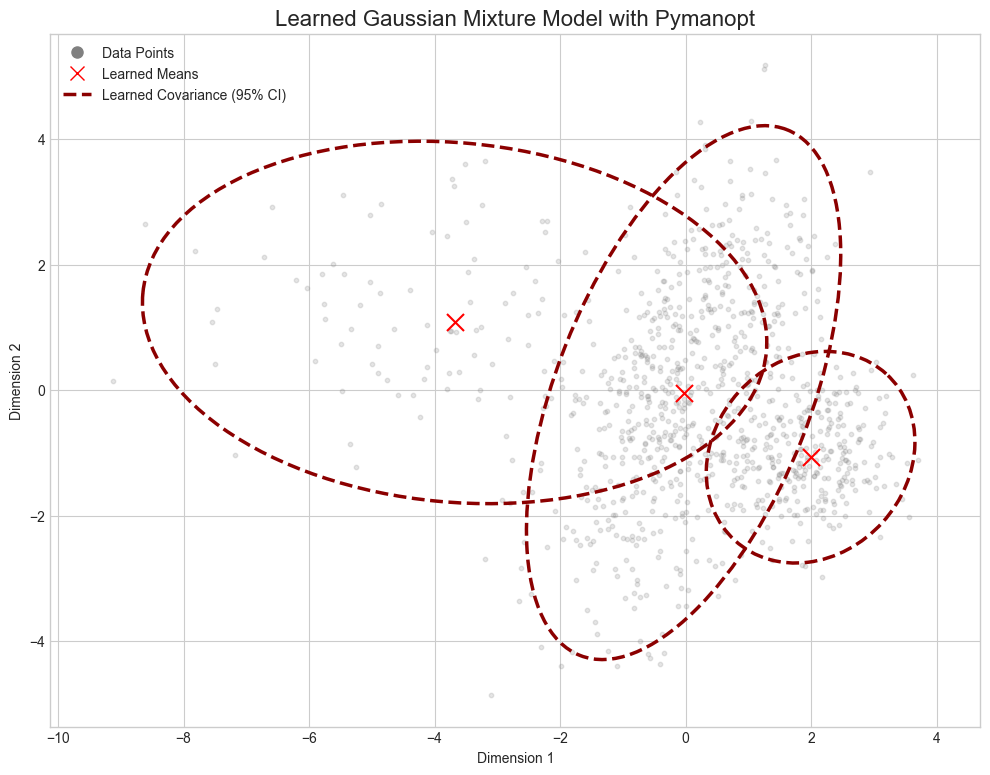

In [6]:
class LineSearchMoG(BackTrackingLineSearcher):
    """
    A custom backtracking line-search class that checks for near-singular matrices.
    It inherits from Pymanopt's standard BackTrackingLineSearcher.
    """
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._oldf0 = None
        
    def search(self, objective, manifold, x, d, f0, df0):
        """
        Performs a backtracking line search.
        If a `LinAlgError` occurs, it resets the problematic matrix.
        """
        # Get a new point and its cost
        newx, newf, was_reset = self._get_new_point_and_cost(x, d, objective, manifold)
        
        # If the matrix was reset, accept the step and continue.
        if was_reset:
            step_size = manifold.norm(x, d) # Preserve step size
            self._oldf0 = f0
            return step_size, newx

        # If the matrix was not reset, proceed with the standard backtracking algorithm.
        # This is done by calling `super().search` to avoid code duplication.
        return super().search(objective, manifold, x, d, f0, df0)

    def _get_new_point_and_cost(self, x, d, objective, manifold):
        """Calculates a new point and its cost, handling resets on error."""
        newx = manifold.retraction(x, d)
        try:
            newf = objective(newx)
            return newx, newf, False  # No error, no reset occurred
        except np.linalg.LinAlgError:
            print("Warning: Singular matrix detected. Resetting cluster parameters.")
            # Find which matrices are singular by checking their condition number
            is_singular = np.array([
                np.linalg.cond(newx[0][k]) > 1 / np.finfo(float).eps
                for k in range(newx[0].shape[0])
            ])
            # Replace the problematic matrices with a new random point from the manifold.
            # We only modify the S matrices (x[0]).
            newx[0][is_singular] = manifold.parts[0].randvec(x[0], is_singular.sum())
            
            # Recalculate the cost with the new, reset point
            newf = objective(newx)
            return newx, newf, True # A reset occurred

# --- Using the `LineSearchMoG` Class ---
print("\n" + "="*70)
print("OPTIMIZATION WITH CUSTOM LINE SEARCH (SINGULARITY-PROTECTED)")
print("="*70)

# Create an instance of our custom line search class
custom_line_searcher = LineSearchMoG()

# Pass this instance to the optimizer via the `line_searcher` parameter
optimizer_with_fix = ConjugateGradient(
    verbosity=1,
    max_iterations=1000,
    line_searcher=custom_line_searcher  # <-- THIS IS THE KEY PART
)

# Run the problem again with this new, robust optimizer
problem_with_fix = Problem(manifold, cost)
result_with_fix = optimizer_with_fix.run(problem_with_fix)
S_opt_fix, v_opt_fix = result_with_fix.point
print("Singularity-protected optimization complete.")

# Analyze and plot the new results
analyze_and_plot_results(samples, S_opt_fix, v_opt_fix, pi, mu, Sigma)